## Spatial Correlation Anomaly Detection Method for Subsurface Modeling
#### Wendi Liu, PhD Student, The University of Texas at Austin
#### Michael Pyrcz, Associate Professor, University of Texas at Austin 
Aug. 2019

### Loading the functions
Note: the functions contains python wrapper for GSLIB. Executable files from GSLIB should be in the same directory

In [1]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import random as rand
import seaborn as sns
from scipy.stats import norm
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python
"""
Functions
"""

def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()
    
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name
# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy] = (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array) 
def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var
def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])


# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)
def random_sample(array,xmin,xmax,ymin,ymax,step,nsamp,name):
    import random as rand
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax-1, ymin-1, -1*step))
    ny = xx.shape[0]
    nx = xx.shape[1]
    rand.seed(9002)
    sample_index = rand.sample(range((nx)*(ny)), nsamp)
    for isamp in range(0,nsamp):
        iy = int(sample_index[isamp]/ny)
        ix = sample_index[isamp] - iy*nx
        x.append(xx[iy,ix])
        y.append(yy[iy,ix])
        v.append(array[iy,ix])
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df) 
# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods (version for subplots)
def locmap_st(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0   
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return im           
def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return

def locpix_diff(
    array,
    xmin,
    xmax,
    ymin,
    ymax,
    step,
    vmin,
    vmax,
    title,
    xlabel,
    ylabel,
    vlabel,
    cmap,
):
    """Pixel plot and location map, reimplementation in Python of a GSLIB MOD
    with Matplotlib methods (version for subplots).
    :param array: ndarray
    :param xmin: x axis minimum
    :param xmax: x axis maximum
    :param ymin: y axis minimum
    :param ymax: y axis maximum
    :param step: step
    :param vmin: TODO
    :param vmax: TODO
    :param df: dataframe
    :param xcol: data for x axis
    :param ycol: data for y axis
    :param vcol: color, sequence, or sequence of color
    :param title: title
    :param xlabel: label for x axis
    :param ylabel: label for y axis
    :param vlabel: TODO
    :param cmap: colormap
    :return: QuadContourSet
    """
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )

    cs = plt.contourf(
        xx,
        yy,
        array,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=np.linspace(vmin, vmax, 100),
    )
   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    cbar =plt.colorbar(ticks=np.linspace(vmin,vmax,9))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs
def Dataframe2GSLIB(data_file, df):
    """Convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB
    methods.

    :param data_file: file name
    :param df: dataframe
    :return: None
    """
    ncol = len(df.columns)
    nrow = len(df.index)

    with open(data_file, "w") as f:
        f.write(data_file + "\n")
        f.write(str(ncol) + "\n")

        for icol in range(ncol):
            f.write(df.columns[icol] + "\n")
        for irow in range(nrow):
            for icol in range(ncol):
                f.write(str(df.iloc[irow, icol]) + " ")
            f.write("\n")
            


def kb2d(df, xcol, ycol, vcol, nx, ny, xsiz, ysiz,nug,nst,it1,cc1,azi1,hmaj1,hmin1, it2,cc2,azi2,hmaj2,hmin2,output_file):
    """Kriging estimation, 2D wrapper for kb2d from GSLIB (.exe must be
    available in PATH or working directory).
    :param df: dataframe
    :param xcol: TODO
    :param ycol: TODO
    :param vcol: TODO
    :param nx: TODO
    :param ny: TODO
    :param hsiz: TODO
    :param var: TODO
    :param output_file: output file
    :return: TODO
    """
    df_temp = pd.DataFrame({"X": df[xcol], "Y": df[ycol], "Var": df[vcol]})
    Dataframe2GSLIB("data_temp.dat", df_temp)

    
    max_range = max(hmaj1, hmaj2)
    xmn = xsiz * 0.5
    ymn = ysiz * 0.5

    with open("kb2d.par", "w") as f:
        f.write("              Parameters for KB2D                                          \n")
        f.write("              ********************                                         \n")
        f.write("                                                                           \n")
        f.write("START OF PARAMETER:                                                        \n")
        f.write("data_temp.dat                         -file with data                      \n")
        f.write("1  2  3                               -  columns for X,Y,vr                \n")
        f.write("-1.0e21   1.0e21                      -   trimming limits                  \n")
        f.write("0                                     -debugging level: 0,1,2,3            \n")
        f.write("none.dbg                              -file for debugging output           \n")
        f.write(str(output_file) + "                   -file for kriged output              \n")
        f.write(str(nx) + " " + str(xmn) + " " + str(xsiz) + "                              \n")
        f.write(str(ny) + " " + str(ymn) + " " + str(ysiz) + "                              \n")
        f.write("1    1                                -x and y block discretization        \n")
        f.write("1    30                               -min and max data for kriging        \n")
        f.write(str(max_range) + "                     -maximum search radius               \n")
        f.write("1    -9999.9                          -0=SK, 1=OK,  (mean if SK)           \n")
        f.write(str(nst) + " " + str(nug) + "          -nst, nugget effect                  \n")
        f.write(str(it1) + " " + str(cc1) + " " + str(azi1) + " " + str(hmaj1) + " " + str(hmin1) + " -it, c ,azm ,a_max ,a_min \n")
        f.write(str(it2) + " " + str(cc2) + " " + str(azi2) + " " + str(hmaj2) + " " + str(hmin2) + " -it, c ,azm ,a_max ,a_min \n")

    os.system("kb2d.exe kb2d.par")
    est_array = GSLIB2ndarray(output_file, 0, nx, ny)
    var_array = GSLIB2ndarray(output_file, 1, nx, ny)
    return est_array[0], var_array[0]

def locpix_st(
    array,
    xmin,
    xmax,
    ymin,
    ymax,
    step,
    vmin,
    vmax,
    df,
    xcol,
    ycol,
    vcol,
    title,
    xlabel,
    ylabel,
    vlabel,
    cmap,
):
    """Pixel plot and location map, reimplementation in Python of a GSLIB MOD
    with Matplotlib methods (version for subplots).
    :param array: ndarray
    :param xmin: x axis minimum
    :param xmax: x axis maximum
    :param ymin: y axis minimum
    :param ymax: y axis maximum
    :param step: step
    :param vmin: TODO
    :param vmax: TODO
    :param df: dataframe
    :param xcol: data for x axis
    :param ycol: data for y axis
    :param vcol: color, sequence, or sequence of color
    :param title: title
    :param xlabel: label for x axis
    :param ylabel: label for y axis
    :param vlabel: TODO
    :param cmap: colormap
    :return: QuadContourSet
    """
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
    )

    cs = plt.contourf(
        xx,
        yy,
        array,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=np.linspace(vmin, vmax, 100),norm=MidpointNormalize(vmax=vmax, midpoint=0.1)
    )
 
    plt.scatter(
        df[xcol],
        df[ycol],
        s=None,
        c=df[vcol],
        marker=None,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.8,
        linewidths=0.8,
        verts=None,
        edgecolors="black",
        norm=MidpointNormalize(vmax=vmax, midpoint=0.1)
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    cbar = plt.colorbar(orientation="vertical")
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

class MidpointNormalize(Normalize):
# Utility function to move the midpoint of a colormap to be around
# the values of interest.
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


### Construction of synthetic data
The data in this study is randomly sampled from a 2D, 2000m by 2000m spatially correlated synthetic geological porosity model. 

The following is the modeling parameters to construct the spatial correlated synthetic geological porosity model

In [2]:
nx = 200; ny = 200; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 73502                                  # random number seed  for stochastic simulation    
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
vmin = 3; vmax = 17; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

por_range=800 
vario1=make_variogram(nug=0.0,nst=2,it1=1,cc1=0.3,azi1=90,hmaj1=200,hmin1=120,it2=1,cc2=0.7,azi2=90,hmaj2=por_range,hmin2=500)
por = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,vario1,"simulation")

por=affine(por,mean,stdev)

df=pd.DataFrame({'Porosity':por.reshape((40000,))})

visualize the synthetic porosity model

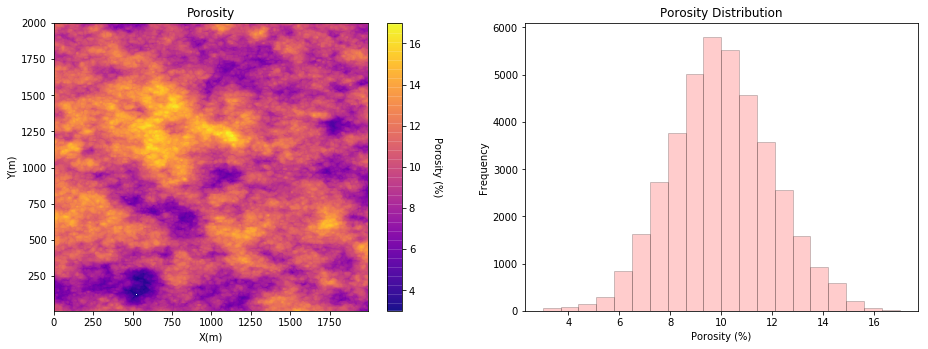

In [38]:
plt.subplot(121)
pixelplt_st(por,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity","X(m)","Y(m)","Porosity (%)",cmap)
plt.subplot(122)
hist_st(por.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Distribution")
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)
plt.savefig('Figure1.tif',dpi=300,bbox_inches="tight")

### Create representative sample

In [4]:
nx = 200; ny = 200; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model

mx = 25; my = 25
sample_data1 = regular_sample(por,xmin,xmax,ymin,ymax,cell_size,mx,my,"Porosity")
nsamp_random = 240
sample_data2 = random_sample(por,xmin,xmax,ymin,ymax,cell_size,nsamp_random,'Porosity')
sample_data = pd.concat([sample_data1,sample_data2],ignore_index = True)

visualize the data sample

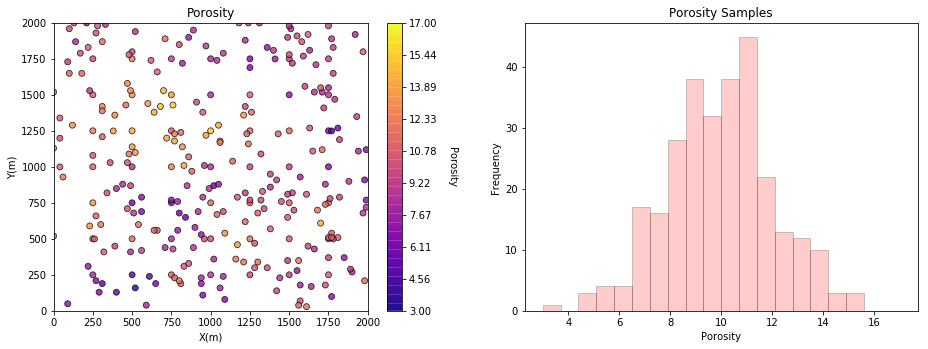

In [39]:
plt.subplot(121)
locmap_st(sample_data,'X','Y','Porosity',xmin,xmax,ymin,ymax,vmin,vmax,'Porosity','X(m)','Y(m)','Porosity',cmap)
plt.subplot(122)
hist_st(sample_data['Porosity'],vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Porosity Samples")
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=1, wspace=0.2, hspace=0.2)
plt.savefig('Figure2.tif',dpi=300,bbox_inches="tight")

visualize the variogram model of the synthetic data

In [6]:
nlag = 1500; xlag = 1; azm1 = 90 
index,h,gam,cov,ro = geostats.vmodel(nlag,xlag,azm1,vario1)
nlag = 1500; xlag = 1; azm2 = 180 
index,h1,gam1,cov,ro = geostats.vmodel(nlag,xlag,azm2,vario1)

 x,y,z offsets = 1.0,1.7948965149208059e-09
 x,y,z offsets = 3.5897930298416118e-09,-1.0


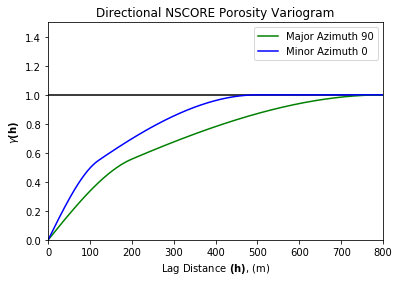

In [40]:
plt.axhline(y=1,color='black')
plt.plot(h,gam,color = 'green',label = "Major Azimuth 90")
plt.plot(h1,gam1,color = 'blue',label = "Minor Azimuth 0")
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,800])
plt.ylim([0,1.5])
plt.legend()
plt.savefig('Figure3.tif',dpi=300,bbox_inches="tight")

#### Specify biavariate Gaussian distribution joint pdf and calculate p-value

In [8]:
def multi_gaussian(rho,head,tail):
    z = head**2-2*rho*head*tail+tail**2
    prob = np.exp(-z/(2*(1-rho**2)))/(2*np.pi*np.sqrt(1-rho))
    return prob

def p_value(nx,ny,rho,ztail,zhead):
    xx = np.linspace(-4, 4, nx)
    yy = np.linspace(-4, 4, ny)
    head,tail = np.meshgrid(xx,yy)
    prob = multi_gaussian(rho,head,tail)
    
    s = prob.sum()
    I = np.sort(prob,axis=None)[::-1]
    joint_density = 0
    times=0
    
    for i in range(len(I)):
        joint_density += I[i]/s
        if (i!=0)&(I[i-1] == I[i]):
            if (head[np.where(prob == I[i])][times+1]>=zhead)&(head[np.where(prob == I[i])][times+1]-8/(nx-1)<zhead)&(tail[np.where(prob == I[i])][times+1]>=ztail)&(tail[np.where(prob == I[i])][times+1]-8/(ny-1)<ztail):
                break
            times += 1 
        else:
            if (head[np.where(prob == I[i])][0]>=zhead)&(head[np.where(prob == I[i])][0]-8/(nx-1)<zhead)&(tail[np.where(prob == I[i])][0]>=ztail)&(tail[np.where(prob == I[i])][0]-8/(ny-1)<ztail):
                break
            times=0
    return 1-joint_density

visualize the joint density function space of one example ($\rho$=0.5)

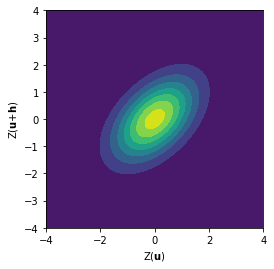

In [9]:
nx=50;ny=50
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
head,tail = np.meshgrid(xx,yy)
plt.contourf(head,tail,multi_gaussian(0.5,head,tail))
plt.ylabel(r'Z($\bf u$+$\bf h$)')
plt.xlabel(r'Z($\bf u$)')
plt.gca().set_aspect('equal', adjustable='box')


Load the function for calculating correlogram from a given pair of data with specific variogram model. The function could be used in 3D problem. Here we used it for the 2D problem by setting z1,z2=0

In [10]:
def sqdist3(x1,y1,z1,x2,y2,z2,ind,rotmat):
    """Squared Anisotropic Distance Calculation Given Matrix Indicator
    
    This routine calculates the anisotropic distance between two points 
    given the coordinates of each point and a definition of the
    anisotropy, converted from original fortran (Deutsch and Journel, 1998) to Python by Wendi Liu.
    
    INPUT VARIABLES:
 
    x1,y1,z1         Coordinates of first point
    x2,y2,z2         Coordinates of second point
    ind              The rotation matrix to use
    rotmat           The rotation matrices"""
    
    dx = x1 - x2
    dy = y1 - y2
    dz = z1 - z2
    sqdist = 0.0
    for i in range(3):
        cont = rotmat[ind, i, 0] * dx + rotmat[ind, i, 1] * dy + rotmat[ind, i, 2] * dz
        sqdist += cont**2
    return sqdist

def setrot3(ang1,ang2,ang3,anis1,anis2,ind,rotmat):
    """Sets up an Anisotropic Rotation Matrix
    
    Sets up the matrix to transform cartesian coordinates to coordinates
    accounting for angles and anisotropy, converted from original fortran (Deutsch and Journel, 1998) to Python by Wendi Liu.
    
    INPUT PARAMETERS:

    ang1             Azimuth angle for principal direction
    ang2             Dip angle for principal direction
    ang3             Third rotation angle
    anis1            First anisotropy ratio
    anis2            Second anisotropy ratio
    ind              matrix indicator to initialize
    rotmat           rotation matrices
    
    Converts the input angles to three angles which make more mathematical sense:

          alpha   angle between the major axis of anisotropy and the
                  E-W axis. Note: Counter clockwise is positive.
          beta    angle between major axis and the horizontal plane.
                  (The dip of the ellipsoid measured positive down)
          theta   Angle of rotation of minor axis about the major axis
                  of the ellipsoid."""
    
    DEG2RAD=np.pi/180.0; EPSLON=1e-20
    if (ang1 >= 0.0)&(ang1<270.0):
        alpha = (90.0 - ang1) * DEG2RAD
    else:
        alpha = (450.0 - ang1) * DEG2RAD
    beta = -1.0 * ang2 *DEG2RAD
    theta = ang3 * DEG2RAD
    
    sina = np.sin(alpha)
    sinb = np.sin(beta)
    sint = np.sin(theta)
    cosa = np.cos(alpha)
    cosb = np.cos(beta)
    cost = np.cos(theta)
    ### Construct the rotation matrix in the required memory
    
    afac1 = 1.0/max(anis1, EPSLON)
    afac2 = 1.0/max(anis2, EPSLON)
    rotmat[ind,0,0] = cosb * cosa
    rotmat[ind,0,1] = cosb * sina
    rotmat[ind,0,2] = -sinb
    rotmat[ind,1,0] = afac1*(-cost*sina + sint*sinb*cosa)
    rotmat[ind,1,1] = afac1*(cost*cosa + sint*sinb*sina)
    rotmat[ind,1,2] = afac1*( sint * cosb)
    rotmat[ind,2,0] = afac2*(sint*sina + cost*sinb*cosa)
    rotmat[ind,2,1] = afac2*(-sint*cosa + cost*sinb*sina)
    rotmat[ind,2,2] = afac2*(cost * cosb)
    
    return rotmat

def cova3(x1,y1,z1,x2,y2,z2,nst,c0,it,cc,aa,rotmat,cmax,ivarg=1,irot=0, MAXNST=4):
    """Covariance Between Two Points
    This function calculated the covariance associated with a variogram
  model specified by a nugget effect and nested varigoram structures,
  converted from original fortran (Deutsch and Journel, 1998) to Python by Wendi Liu.
  
  The anisotropy definition can be different for each nested structure. """
    
    """
    INPUT VARIABLES:

    x1,y1,z1         coordinates of first point
    x2,y2,z2         coordinates of second point
    nst             number of nested structures (maximum of 4)
    ivarg            variogram number (set to 1 unless doing cokriging
                        or indicator kriging)
    MAXNST           size of variogram parameter arrays
    c0              isotropic nugget constant
    it               type of each nested structure:
                       1. spherical model of range a;
                       2. exponential model of parameter a;
                            i.e. practical range is 3a
                       3. gaussian model of parameter a;
                            i.e. practical range is a*sqrt(3)
                       4. power model of power a (a must be greater than 0  and
                            less than 2).  if linear model, a=1,c=slope.
    cc               multiplicative factor of each nested structure.
                       (sill-c0) for spherical, exponential,and gaussian
                       slope for linear model.
    aa               parameter "a" of each nested structure.
    irot             index of the rotation matrix for the first nested 
                     structure (irot starts from 0; the second nested structure will use
                     irot+1, the third irot+2, and so on)
    rotmat           rotation matrices"""
    
    EPSLON = 1e-10
    PMX=1e10
    ### Calculate the maximum covariance value (used for zero distances and for power model covariance):
    istart = 1+ (ivarg-1) * MAXNST
    
    for ii in range(nst):##nst[ivarg-1] if ivarg>1
        ist = istart+ ii-1
        if it[ist] == 4:
            cmax = cmax+PMX
        else:
            cmax = cmax+cc[ist]
        
    # Check for very small distance
    hsqd = sqdist3(x1,y1,z1,x2,y2,z2,irot,rotmat)
    if hsqd < EPSLON:
        cova = cmax
        return cmax,cova
    
    # Non-zero distance, loop over all the structures
    cova = 0.0
    for js in range(nst):##nst[ivarg-1] if ivarg>1
        ist = istart+js-1
        # Compute the appropriate structural distance
#         if ist!=0:
#             ir = min((irot+js),MAXROT)
#             hsqd = sqdist(x1,y1,z1,x2,y2,z2,ir,MAXROT,rotmat)
        h = np.sqrt(hsqd)
        if it[ist] == 1: ##Spherical
            hr = h/aa[ist]
            if hr<1:
                cova+=cc[ist]*(1.0-hr*(1.5-0.5*hr*hr))
        elif it[ist] == 2: ##Exponential
            cova += cc[ist]*np.exp(-3.0*h/aa[ist])
        elif it[ist] == 3: ##Gaussian
            cova += cc[ist]*np.exp(-(3.0*h/aa[ist])*(3.0*h/aa[ist]))
        elif it[ist] == 4: ##Power
            cova += cmax-cc[ist]*h**aa[ist]
            
    return cmax, cova

In [11]:
def correlavario(x1, y1, x2, y2,nst=2,c0=0,azi =90, it=[1,1],cc=[0.3,0.7],hmaj=[200,800],hmin = [120,500],hvert=[0,0]):
    ###Initialization
    rotmat = np.zeros((5, 3, 3))
    EPSLON = 1.0e-20
    MAXNST=4
    maxcov=1.0
    cmax = c0
    ang1 = np.ones((MAXNST,))*azi #azimuth
    ang2 = np.zeros((MAXNST,)) #dip
    ang3 = np.zeros((MAXNST,)) #plenge
    anis1 = np.zeros((MAXNST,))
    anis2 = np.zeros((MAXNST,))
    
    for i in range(nst):
        anis1[i] = hmin[i]/max(hmaj[i],EPSLON)
        anis2[i] = hvert[i]/max(hmaj[i],EPSLON)
        rotmat = setrot3(ang1[i],ang2[i],ang3[i],anis1[i],anis2[i],i,rotmat)
    cmax,cova = cova3(x1,y1,0,x2,y2,0,nst,c0,it,cc,hmaj,rotmat,cmax)
    
    return cova


Covert the sample dataset into normalized Gaussian distribution

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


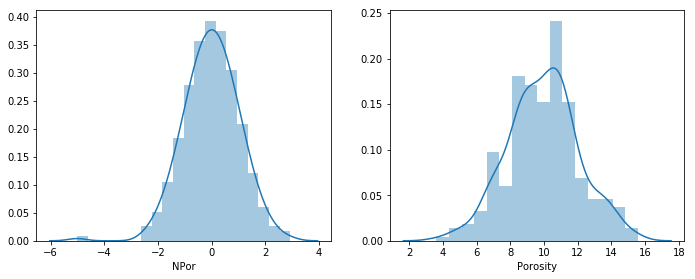

In [12]:
sample_data['NPor'], tvGR, tnsGR = geostats.nscore(sample_data, 'Porosity')
plt.subplot(121)
sns.distplot(sample_data['NPor'], hist=True)
plt.subplot(122)
sns.distplot(sample_data['Porosity'], hist=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.2, hspace=0.2)

### Construction of data pairs for p-value calculation

First we try the Delaunay Tessellation

In [13]:
from scipy.spatial import Delaunay
points=sample_data.loc[:,['X','Y']].values
tri = Delaunay(points)

visualize the data pairs

Text(0,0.5,'Y (m)')

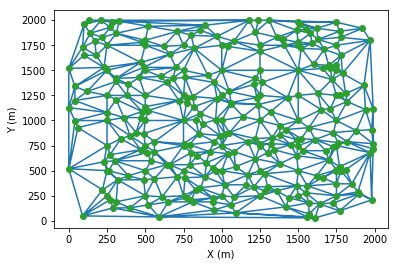

In [14]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

Iterate over all the conbination and return the p-value. The lag with p-value below 5% is labeled as red. The p-value of the lag vector is then assigned to the vector centroid.

In [15]:
def distance(arr1,arr2):##Input: simplex vertices coordinates
    """
    A simple euclidean distance function
    """
    return math.sqrt((arr1[0] - arr2[0]) ** 2+(arr1[1] - arr2[1]) ** 2)

def plot_centroid(df_tail,df_head,p,rho,i,j):
    df_mid.iloc[3*j+i,:]['X'] = (df_tail['X']+df_head['X'])/2
    df_mid.iloc[3*j+i,:]['Y'] = (df_tail['Y']+df_head['Y'])/2
    df_mid.iloc[3*j+i,:]['pvalue'] = p
    df_mid.iloc[3*j+i,:]['cova'] = rho
    df_mid.iloc[3*j+i,:]['porosity'] = (df_tail['Porosity']+df_head['Porosity'])/2
    if p <= 0.05:
        plt.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'r-',alpha = 0.8)
    else:
        plt.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'k-',alpha = 0.2)






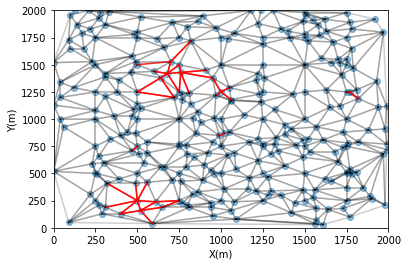

In [41]:
nx = 50;ny = 50
dist = np.zeros((3,))
df_mid=pd.DataFrame(data={"pvalue": np.zeros((3*len(points[tri.simplices]),)),"porosity": np.zeros((3*len(points[tri.simplices]),)),"cova": np.zeros((3*len(points[tri.simplices]),)),"X": np.zeros((3*len(points[tri.simplices]),)),"Y": np.zeros((3*len(points[tri.simplices]),))})
j = 0
for simplex in points[tri.simplices]:
    zhead = pd.DataFrame()
    ztail = pd.DataFrame()
    for i in range(3):
        if i!=2:
            dist[i] = distance(simplex[i],simplex[i+1])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[i+1][0])&(sample_data['Y']==simplex[i+1][1])]])
        else:
            dist[i] = distance(simplex[i],simplex[0])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[0][0])&(sample_data['Y']==simplex[0][1])]])
    for i in range(3):
        rho = correlavario(zhead.iloc[i,:]['X'], zhead.iloc[i,:]['Y'], ztail.iloc[i,:]['X'], ztail.iloc[i,:]['Y'])
#         cloud = correlated_var(rho,sample_data.NPor.values)
#         xmax=cloud[0].max();ymax=cloud[1].max();xmin=cloud[0].min();ymin=cloud[1].min()
#         p = p_value(nx,ny,xmin,xmax,ymin,ymax,cloud,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        p = p_value(nx,ny,rho,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        plot_centroid(ztail.iloc[i,:],zhead.iloc[i,:],p,rho,i,j)
    j+=1
plt.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.savefig('Figure5.tif',dpi=300,bbox_inches="tight")

Check the p-value dataframe. There could be muliple p-value at the same location. Since the p-value is supposed to be symmetric, for the same head and tail value conbination should have the same p-value (or very similar depending on the convergence of the discretization). Therefore, we can take the average of the p-value at the same location. 

In [17]:
df_map = df_mid.groupby(['X','Y'], as_index=False).mean()

Now, we compare another way to construct data pairs other than Delaunay Tessellation - k-nearest neighbor, k=5

In [18]:

def plot_vector(df_tail,df_head,p,rho,i,j):
    df_mid.iloc[k_num*i+j,:]['X'] = (df_tail['X']+df_head['X'])/2
    df_mid.iloc[k_num*i+j,:]['Y'] = (df_tail['Y']+df_head['Y'])/2
    df_mid.iloc[k_num*i+j,:]['pvalue'] = p
    df_mid.iloc[k_num*i+j,:]['cova'] = rho
    df_mid.iloc[k_num*i+j,:]['porosity'] = (df_tail['Porosity']+df_head['Porosity'])/2
    if p <= 0.05:
        plt.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'r-',alpha = 0.8)
    else:
        plt.plot([df_head['X'],df_tail['X']],[df_head['Y'],df_tail['Y']],'k-',alpha = 0.2)


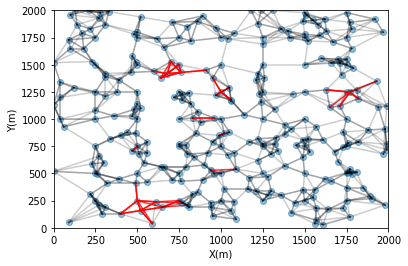

In [19]:
def euclidean_distance(df):
    """
    A simple euclidean distance function
    """
    return math.sqrt((df['X'] - data['X']) ** 2+(df['Y'] - data['Y']) ** 2)
#####
##Bivariate Gaussain joint pdf method
#####
k_num=5
nx = 50;ny = 50
df_mid=pd.DataFrame(data={"pvalue": np.zeros((k_num*len(sample_data),)),"porosity": np.zeros((k_num*len(sample_data),)),"cova": np.zeros((k_num*len(sample_data),)),"X": np.zeros((k_num*len(sample_data),)),"Y": np.zeros((k_num*len(sample_data),))})
for rows, data in sample_data.iterrows():
    dist = sample_data.apply(lambda x: euclidean_distance(x), axis=1)
    # Create a new dataframe with distances.
    distance_frame = pd.DataFrame(data={"dist": dist})
    distance_frame.sort_values("dist", inplace=True)
    # Find the most similar (the lowest distance to the data is itself, the second smallest is the most similar ones)
    local_smallest = distance_frame.iloc[1:k_num+1].index
    nearest_neighbor = sample_data.loc[local_smallest]
    nearest_neighbor['dist'] = distance_frame.iloc[1:k_num+1].dist
    nearest_neighbor = nearest_neighbor.reset_index()
    for i,local in nearest_neighbor.iterrows():
        rho = correlavario(data['X'], data['Y'], local['X'], local['Y'])
        zhead = data['NPor']
        ztail = local['NPor']
        p = p_value(nx,ny,rho,ztail,zhead)
        plot_vector(local,data,p,rho,rows,i)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)


Take the average of the p value at the same location.

In [20]:
df_map_kn = df_mid.groupby(['X','Y'], as_index=False).mean()

Use the centroid to construct p-value estimation map of the two methods via kriging.

In [21]:
nx = 200; ny = 200
xsiz = 10;ysiz = 10;nug = 0;nst = 2
###Kriging map for p-value from Delaunay tessellation

it1 = 2; cc1 = 0.7;azi1 = 90; hmaj1 = 400; hmin1 =350
it2 = 2; cc2 = 0.3;azi2=90; hmaj2 = 650; hmin2 = 600
est,var = kb2d(df_map, 'X', 'Y', 'pvalue', nx, ny, xsiz,ysiz, nug,nst,it1,cc1,azi1,hmaj1,hmin1, it2,cc2,azi2,hmaj2,hmin2,'output_file')

In [22]:
nx = 200; ny = 200
xsiz = 10;ysiz = 10;nug = 0.15;nst = 2
###Kriging map for p-value from k-nearest neighbor.

it1 = 2; cc1 = 0.55;azi1 = 0; hmaj1 = 320; hmin1 =320
it2 = 3; cc2 = 0.25;azi2=0; hmaj2 = 650; hmin2 = 400

est_kn,var_kn = kb2d(df_map_kn, 'X', 'Y', 'pvalue', nx, ny, xsiz,ysiz, nug,nst,it1,cc1,azi1,hmaj1,hmin1, it2,cc2,azi2,hmaj2,hmin2,'output_file')


Truncate estimated negative value to 0

In [23]:
est[np.where(est<0)] = np.zeros((est[np.where(est<0)].shape))
est_kn[np.where(est_kn<0)] = np.zeros((est_kn[np.where(est_kn<0)].shape))

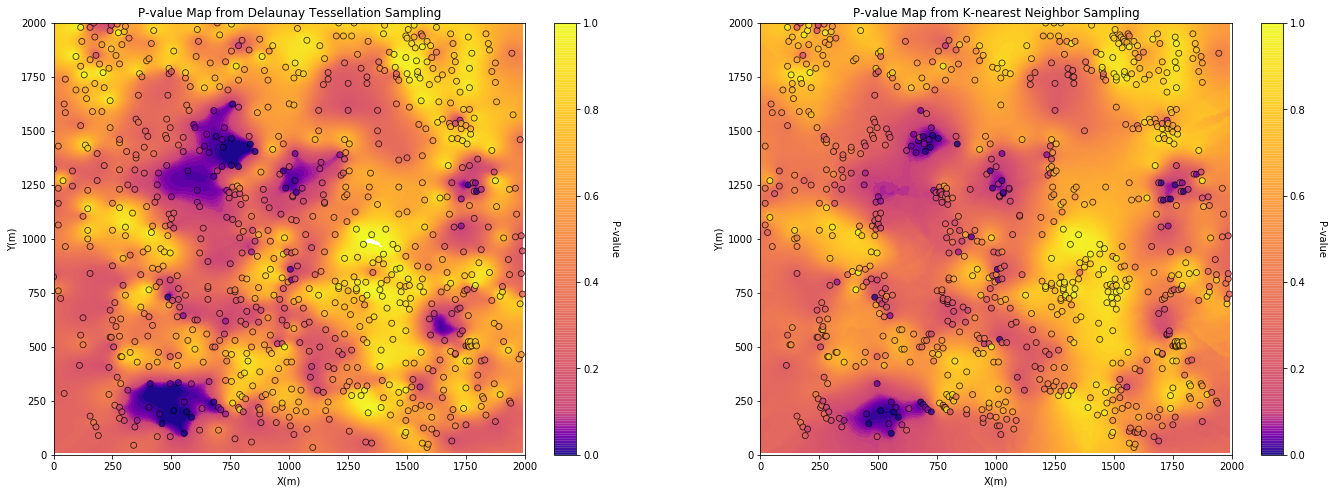

In [42]:
xmin=0;xmax=2000;ymin=0;ymax=2000
plt.subplot(121)
locpix_st(est,xmin,xmax,ymin,ymax,xsiz,0.0,1,df_map,'X','Y','pvalue','P-value Map from Delaunay Tessellation Sampling','X(m)','Y(m)','P-value',cmap='plasma')
plt.subplot(122)
locpix_st(est_kn,xmin,xmax,ymin,ymax,xsiz,0.0,1,df_map_kn,'X','Y','pvalue','P-value Map from K-nearest Neighbor Sampling','X(m)','Y(m)','P-value',cmap='plasma')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.savefig('Figure6.tif',dpi=300,bbox_inches="tight")

Plot the two kriging map absolute difference

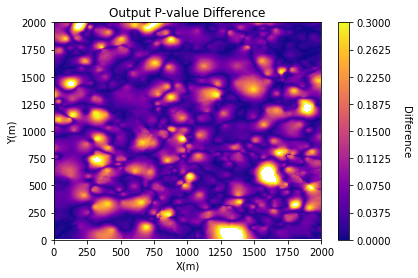

In [43]:
diff = abs(est-est_kn)
locpix_diff(diff,xmin,xmax,ymin,ymax,xsiz,0.0,0.3,'Output P-value Difference','X(m)','Y(m)','Difference',cmap)
plt.savefig('Figure7.tif',dpi=300,bbox_inches="tight")

According to the comparison, the two methods produce similar results while the lags from Delaunay tessellation would cover more area than k-nearest neighbor. The most significantly different regions are where the k-nearest neighbor method does not have lag vector centroids

Therefore, here the tessellation is a more preferential way of lag vector construction as it is able to integrate the sparse, clustered well samples better than k nearest neighbors. 

Check the p-value conditional statistics of the the average of the tail and head porosity values from Delaunay tessellation

In [26]:
por_bins = np.linspace(3,16,6)  # set the bin boundaries and then the centroids for plotting
por_centroids = np.linspace((por_bins[0]+por_bins[1])*0.5,(por_bins[4]+por_bins[5])*0.5,5)
print(por_bins,por_centroids)

[ 3.   5.6  8.2 10.8 13.4 16. ] [ 4.3  6.9  9.5 12.1 14.7]


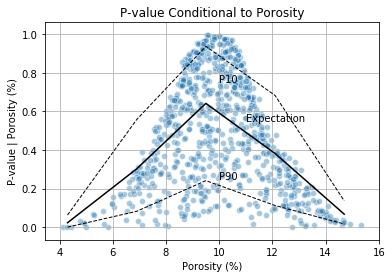

In [44]:

df_map['por_bins'] = pd.cut(df_map['porosity'],por_bins,labels=por_centroids)


cond_exp = df_map.groupby('por_bins')['pvalue'].mean()
cond_P90 = df_map.groupby('por_bins')['pvalue'].quantile(.9)
cond_P10 = df_map.groupby('por_bins')['pvalue'].quantile(.1)

plt.plot(por_centroids,cond_exp,color='black')
plt.plot(por_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(por_centroids,cond_P10,'r--',color='black',linewidth = 1.0)
plt.scatter(df_map['porosity'],df_map['pvalue'],alpha=0.4,edgecolor='white')
plt.xlabel('Porosity (%)')
plt.ylabel('P-value | Porosity (%)')
t = plt.title('P-value Conditional to Porosity')

# plt.xlim(2)
plt.grid(True)

plt.text(10, 0.25, 'P90')
plt.text(11, 0.55, 'Expectation')
plt.text(10, 0.75, 'P10')

plt.savefig('Figure8.tif',dpi=300,bbox_inches="tight")

We can observe that extreme porosity at the tails in the distribution tends to have smaller p-value, which indicates porosity magnitude could possibly have impact on the p-value.

To account for the impact of changes in spatial continuity with magnitude, the indicator variogram for the bivariate Gaussian distribution is applied to update the spatial continuity model.

###  Indicator variogram for bivariate Gaussian post-processing

In [28]:
def funcf(x,z):
    """This function calculates the value of the function
    f( zc, xi)= exp ( -zc**2/ (1+sin(x))) for zc and x"""
    f = np.exp(-z**2/(1+np.sin(x)))
    return f

def funcg(x,z):
    g = np.exp(-x**2/2.0)
    return g


In [29]:
from scipy import integrate
def simpson(alim,blim,z,f):
    if alim == blim:
        value = 0
    elif blim>alim: 
        x = np.arange(alim,blim,0.001)
        y = f(x,z)
        value = integrate.simps(y,x)
    else:
        x = np.arange(alim,blim,-0.001)
        y = f(x,z)
        value = integrate.simps(y,x)
    return value

In [30]:

def bigaus(x1, y1, x2, y2, z_centroid, nst=2,c0=0,azi =90, it=[1,1],cc=[0.3,0.7],hmaj=[200,800],hmin = [120,500],hvert=[0,0]):
    """
    The bigaus function is converted from fortran GSLIB (Deutsch and Journel, 1992) to Python by Wendi Liu
    ncut:number of cutoffs
    zc: cutoffs, in ascending order"""
    ###Initialization
    rotmat = np.zeros((5, 3, 3))
    DEG2RAD = np.pi/180
    EPSLON = 1.0e-20
    MAXNST=4
    maxcov=1.0
    cmax = c0
    ang1 = np.ones((MAXNST,))*azi #azimuth
    ang2 = np.zeros((MAXNST,)) #dip
    ang3 = np.zeros((MAXNST,)) #plenge
    anis1 = np.zeros((MAXNST,))
    anis2 = np.zeros((MAXNST,))
    #### Set up the rotation matrices
    for i in range(nst):
        anis1[i] = hmin[i]/max(hmaj[i],EPSLON)
        anis2[i] = hvert[i]/max(hmaj[i],EPSLON)
        rotmat = setrot3(ang1[i],ang2[i],ang3[i],anis1[i],anis2[i],i,rotmat)
    #### Convert cutoffs cumulative probabilities to standard normal cutoffs:
#     for i in range(ncut):
#         zc[i] = gauinv(zc[i]) 
    cmax,cova = cova3(x1,y1,0,x2,y2,0,nst,c0,it,cc,hmaj,rotmat,cmax)
    ro = cova/maxcov
    #### Loop over all cutoffs
    ci0 = simpson(0.0,np.pi/2,z_centroid,funcf)
    p = simpson(0.0,z_centroid,z_centroid,funcg)
    p = 0.5 + p/np.sqrt(2*np.pi)
    b = np.arcsin(ro)
    ci = simpson(0.0, b,z_centroid,funcf)
    ri = (ci0-ci)/(2*np.pi)
    rop = ri/(p*(1-p))
    c = 1-rop
    return c
            
            

Update the correlogram value from the previous workflow to the normalized indicator correlogram to calculate the p-value.

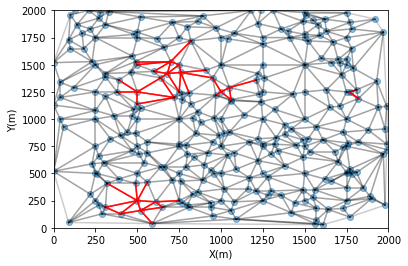

In [45]:
nx = 50;ny = 50
dist = np.zeros((3,))
df_mid=pd.DataFrame(data={"pvalue": np.zeros((3*len(points[tri.simplices]),)),"porosity": np.zeros((3*len(points[tri.simplices]),)),"cova": np.zeros((3*len(points[tri.simplices]),)),"X": np.zeros((3*len(points[tri.simplices]),)),"Y": np.zeros((3*len(points[tri.simplices]),))})
j = 0
for simplex in points[tri.simplices]:
    zhead = pd.DataFrame()
    ztail = pd.DataFrame()
    for i in range(3):
        if i!=2:
            dist[i] = distance(simplex[i],simplex[i+1])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[i+1][0])&(sample_data['Y']==simplex[i+1][1])]])
        else:
            dist[i] = distance(simplex[i],simplex[0])
            zhead = pd.concat([zhead,sample_data[(sample_data['X']==simplex[i][0])&(sample_data['Y']==simplex[i][1])]])
            ztail = pd.concat([ztail,sample_data[(sample_data['X']==simplex[0][0])&(sample_data['Y']==simplex[0][1])]])
    for i in range(3):
        z_centroid = (ztail.iloc[i,:]['NPor']+zhead.iloc[i,:]['NPor'])/2
        rho = bigaus(zhead.iloc[i,:]['X'], zhead.iloc[i,:]['Y'], ztail.iloc[i,:]['X'], ztail.iloc[i,:]['Y'],z_centroid)
#         cloud = correlated_var(rho,sample_data.NPor.values)
#         xmax=cloud[0].max();ymax=cloud[1].max();xmin=cloud[0].min();ymin=cloud[1].min()
#         p = p_value(nx,ny,xmin,xmax,ymin,ymax,cloud,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        p = p_value(nx,ny,rho,ztail.iloc[i,:]['NPor'],zhead.iloc[i,:]['NPor'])
        plot_centroid(ztail.iloc[i,:],zhead.iloc[i,:],p,rho,i,j)
    j+=1
plt.scatter(sample_data['X'],sample_data['Y'],alpha=0.5)
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.savefig('Figure11.tif',dpi=300,bbox_inches="tight")

In [32]:
### take the average of the p value at the same location
df_map_bigaus = df_mid.groupby(['X','Y'], as_index=False).mean()

By checking the correlogram difference from the two methods conditional to the porosity, we can  observe that the correlogram at tail of the distribution changes the most compared with that at median, which indicates the relation between the spatial correlation and magnitude.

In [51]:
diff=pd.DataFrame({'porosity':df_map['porosity'],'pvalue':df_map['pvalue'],'rhodiff':df_map_bigaus['cova']-df_map['cova'], 'pdiff':df_map['pvalue']-df_map_bigaus['pvalue']})

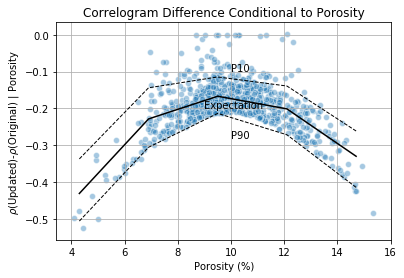

In [52]:
diff['por_bins'] = pd.cut(diff['porosity'],por_bins,labels=por_centroids)


cond_exp_diff = diff.groupby('por_bins')['rhodiff'].mean()
cond_P90_diff = diff.groupby('por_bins')['rhodiff'].quantile(.9)
cond_P10_diff = diff.groupby('por_bins')['rhodiff'].quantile(.1)

plt.plot(por_centroids,cond_exp_diff,color='black')
plt.plot(por_centroids,cond_P90_diff,'r--',color='black',linewidth = 1.0)
plt.plot(por_centroids,cond_P10_diff,'r--',color='black',linewidth = 1.0)
plt.scatter(diff['porosity'],diff['rhodiff'],alpha=0.4,edgecolor='white')
plt.xlabel('Porosity (%)')
plt.ylabel(r'$\rho$(Updated)-$\rho$(Original) | Porosity')
t = plt.title('Correlogram Difference Conditional to Porosity')

# plt.xlim(2)
plt.grid(True)

plt.text(10, -0.28, 'P90')
plt.text(9, -0.2, 'Expectation')
plt.text(10, -0.1, 'P10')
plt.savefig('Figure10.tif',dpi=300,bbox_inches="tight")

Check the p-value with the new workflow conditional statistics of the the average of the tail and head porosity values from Delaunay tessellation

In [35]:
por_bins = np.linspace(3,16,6)  # set the bin boundaries and then the centroids for plotting
por_centroids = np.linspace((por_bins[0]+por_bins[1])*0.5,(por_bins[4]+por_bins[5])*0.5,5)
print(por_bins,por_centroids)

[ 3.   5.6  8.2 10.8 13.4 16. ] [ 4.3  6.9  9.5 12.1 14.7]


Text(10,0.7,'P10')

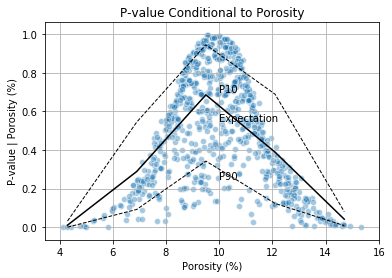

In [36]:

df_map_bigaus['por_bins'] = pd.cut(df_map_bigaus['porosity'],por_bins,labels=por_centroids)


cond_exp_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].mean()
cond_P90_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].quantile(.9)
cond_P10_bigaus = df_map_bigaus.groupby('por_bins')['pvalue'].quantile(.1)

plt.plot(por_centroids,cond_exp_bigaus,color='black')
plt.plot(por_centroids,cond_P90_bigaus,'r--',color='black',linewidth = 1.0)
plt.plot(por_centroids,cond_P10_bigaus,'r--',color='black',linewidth = 1.0)
plt.scatter(df_map_bigaus['porosity'],df_map_bigaus['pvalue'],alpha=0.4,edgecolor='white')
plt.xlabel('Porosity (%)')
plt.ylabel('P-value | Porosity (%)')
t = plt.title('P-value Conditional to Porosity')

# plt.xlim(2)
plt.grid(True)

plt.text(10, 0.25, 'P90')
plt.text(10, 0.55, 'Expectation')
plt.text(10, 0.7, 'P10')



Compare the expectation curve of the two methods

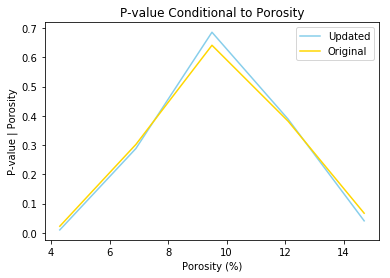

In [47]:
plt.plot(por_centroids,cond_exp_bigaus,color='skyblue',label='Updated')
plt.plot(por_centroids,cond_exp,color='gold',label='Original')
plt.xlabel('Porosity (%)')
plt.ylabel('P-value | Porosity')
t = plt.title('P-value Conditional to Porosity')
plt.legend()
plt.savefig('Figure12.tif',dpi=300,bbox_inches="tight")

It is observed that the impact of the spatial continuity and magnitude relation will impact the  proposed anomaly detection and affect the p-value. 

### Conclusion

* The proposed spatial correlation anomaly detection method  integrates geoscience and engineering expertise into the workflow via trend modeling and variogram modeling and assist with spatial segmentation. Spatial segmentation is critical to build spatial, subsurface models with accuracy.  

* The use of variogram models, converted to correlograms combined with the bivariate Gaussian distribution of the h-scatter plot provide a practical method to assess a pairwise spatial sample data continuity associated p-value. The influence of the relation between spatial continuity and magnitude on p-value is included by implementing the indicator correlogram for bivariate Gaussian distribution. 

* For the field case application where bivariate Gaussian assumption does not necessarily hold, the sample data can be converted to indicator function and fit with an indicator variogram model to correct the p-value for anomaly detection.